# MATH/CSCI 485 – Assignment #2
## Recursive Feature Elimination with Linear Regression
**Dataset:** Scikit-learn Diabetes Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

print('Libraries loaded successfully.')

Libraries loaded successfully.


## Task 1: Dataset Exploration

In [2]:
# 1. Load dataset
diabetes = load_diabetes()
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = pd.Series(diabetes.target, name='target')

print('Feature names:', diabetes.feature_names)
print('\nDataset shape:', X.shape)
print('\nFirst 5 rows:')
display(X.head())

Feature names: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

Dataset shape: (442, 10)

First 5 rows:


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


=== Feature Summary Statistics ===


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000
mean,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000
std,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476
min,-0.1072,-0.0446,-0.0903,-0.1124,-0.1268,-0.1156,-0.1023,-0.0764,-0.1261,-0.1378
25%,-0.0373,-0.0446,-0.0342,-0.0367,-0.0342,-0.0304,-0.0351,-0.0395,-0.0332,-0.0332
50%,0.0054,-0.0446,-0.0073,-0.0057,-0.0043,-0.0038,-0.0066,-0.0026,-0.0019,-0.0011
75%,0.0381,0.0507,0.0312,0.0356,0.0284,0.0298,0.0293,0.0343,0.0324,0.0279
max,0.1107,0.0507,0.1706,0.1320,0.1539,0.1988,0.1812,0.1852,0.1336,0.1356



Target variable: min=25.0, max=346.0, mean=152.13, std=77.09


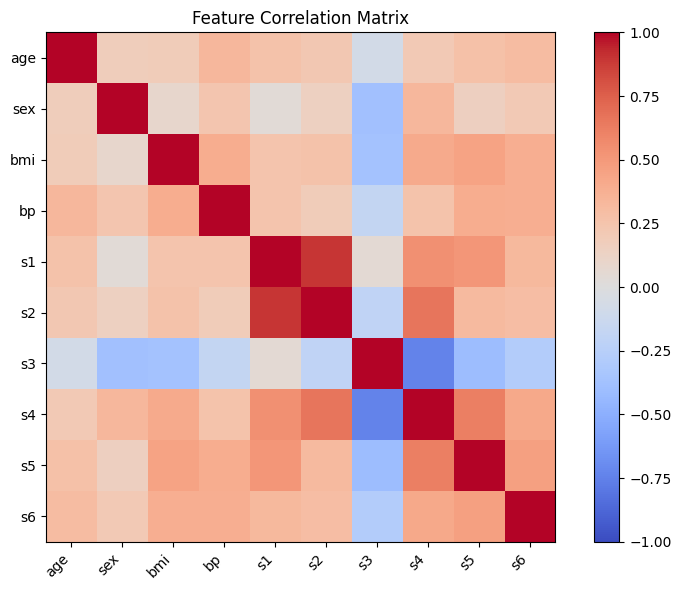

In [3]:
# 2. Explore dataset
print('=== Feature Summary Statistics ===')
display(X.describe().round(4))
print(f'\nTarget variable: min={y.min():.1f}, max={y.max():.1f}, mean={y.mean():.2f}, std={y.std():.2f}')

# Correlation heatmap
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
corr = X.corr()
im = ax.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xticks(range(len(X.columns)))
ax.set_yticks(range(len(X.columns)))
ax.set_xticklabels(X.columns, rotation=45, ha='right')
ax.set_yticklabels(X.columns)
ax.set_title('Feature Correlation Matrix')
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

In [4]:
# 3. 80-20 train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f'Training set:  {X_train.shape[0]} samples')
print(f'Test set:      {X_test.shape[0]} samples')

Training set:  353 samples
Test set:      89 samples


## Task 2: Linear Regression Model (All Features)

In [5]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_full = lr.predict(X_test)
full_r2 = r2_score(y_test, y_pred_full)
print(f'Full model R² score (10 features): {full_r2:.4f}')

coeff_series = pd.Series(lr.coef_, index=diabetes.feature_names)
print('\nCoefficients:')
display(coeff_series.sort_values(key=abs, ascending=False).to_frame('Coefficient').round(3))

Full model R² score (10 features): 0.4526

Coefficients:


,Coefficient
s1,-931.489
s5,736.199
bmi,542.429
s2,518.062
bp,347.704
s4,275.318
sex,-241.964
s3,163.420
s6,48.671
age,37.904


## Task 3: Recursive Feature Elimination (RFE)

In [6]:
feature_names = list(diabetes.feature_names)
n_features = len(feature_names)
r2_scores = []
coeff_records = []

for n in range(n_features, 0, -1):
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=n)
    rfe.fit(X_train, y_train)
    
    selected = [feature_names[i] for i in range(n_features) if rfe.support_[i]]
    eliminated = [feature_names[i] for i in range(n_features) if not rfe.support_[i]]
    r2 = r2_score(y_test, rfe.predict(X_test))
    r2_scores.append({'n_features': n, 'R2': r2, 'selected': selected, 'eliminated': eliminated})
    
    m = LinearRegression().fit(X_train[selected], y_train)
    row = {f: 0.0 for f in feature_names}
    for feat, coef in zip(selected, m.coef_):
        row[feat] = coef
    row['n_features'] = n
    row['R2'] = r2
    coeff_records.append(row)

r2_df = pd.DataFrame(r2_scores)
coeff_df = pd.DataFrame(coeff_records).set_index('n_features')

print('R² at each iteration:')
display(r2_df[['n_features','R2']].round(4))

R² at each iteration:


,n_features,R2
0,10,0.4526
1,9,0.4587
2,8,0.4559
3,7,0.4583
4,6,0.4628
5,5,0.4382
6,4,0.4464
7,3,0.4451
8,2,0.4523
9,1,0.2334


Optimal number of features (Δ≥0.01 threshold): 6


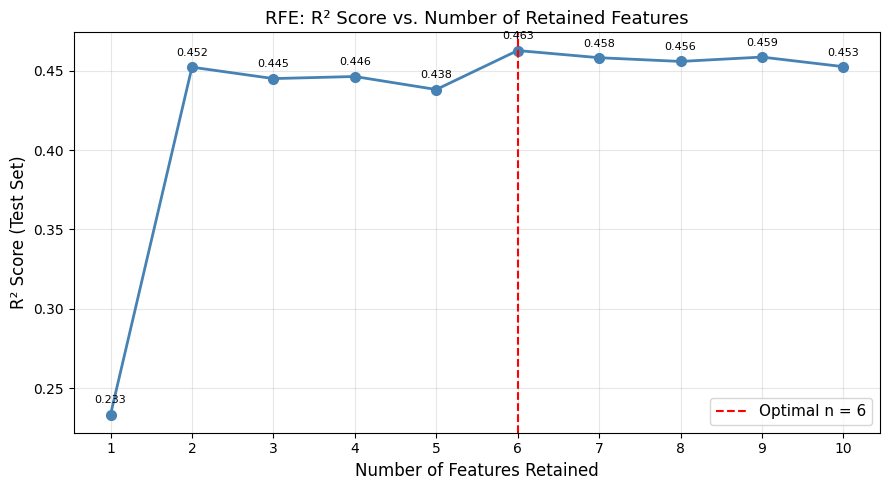

In [7]:
# Optimal number of features using 0.01 threshold
r2_vals = r2_df['R2'].values[::-1]
n_vals  = r2_df['n_features'].values[::-1]
optimal_n = n_vals[0]
for i in range(1, len(r2_vals)):
    if r2_vals[i] - r2_vals[i-1] >= 0.01:
        optimal_n = n_vals[i]
print(f'Optimal number of features (Δ≥0.01 threshold): {optimal_n}')

# Plot R² vs n_features
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(r2_df['n_features'], r2_df['R2'], 'o-', color='steelblue', lw=2, markersize=7)
ax.axvline(optimal_n, color='red', linestyle='--', label=f'Optimal n = {optimal_n}')
for _, row in r2_df.iterrows():
    ax.annotate(f"{row['R2']:.3f}", (row['n_features'], row['R2']),
                textcoords='offset points', xytext=(0, 8), ha='center', fontsize=8)
ax.set_xlabel('Number of Features Retained', fontsize=12)
ax.set_ylabel('R² Score (Test Set)', fontsize=12)
ax.set_title('RFE: R² Score vs. Number of Retained Features', fontsize=13)
ax.set_xticks(range(1, n_features+1))
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Task 4: Feature Importance Analysis

In [8]:
# Coefficient table across iterations
print('=== Coefficient Table at Each RFE Iteration ===')
display(coeff_df[feature_names].round(2))

=== Coefficient Table at Each RFE Iteration ===


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
n_features,,,,,,,,,,
10,37.9,-241.96,542.43,347.70,-931.49,518.06,163.42,275.32,736.20,48.67
9,0.0,-236.65,542.80,354.21,-936.35,528.80,167.80,270.40,744.45,53.35
8,0.0,-233.75,550.74,363.79,-947.82,541.59,172.25,277.74,761.92,0.00
7,0.0,-235.36,551.87,362.36,-660.64,343.35,0.00,185.14,664.77,0.00
6,0.0,-215.27,557.31,350.18,-851.52,591.09,0.00,0.00,803.12,0.00
5,0.0,0.00,597.89,306.65,-655.56,409.62,0.00,0.00,728.64,0.00
4,0.0,0.00,691.46,0.00,-592.98,362.95,0.00,0.00,783.17,0.00
3,0.0,0.00,737.69,0.00,-228.34,0.00,0.00,0.00,680.22,0.00
2,0.0,0.00,732.11,0.00,0.00,0.00,0.00,0.00,562.23,0.00


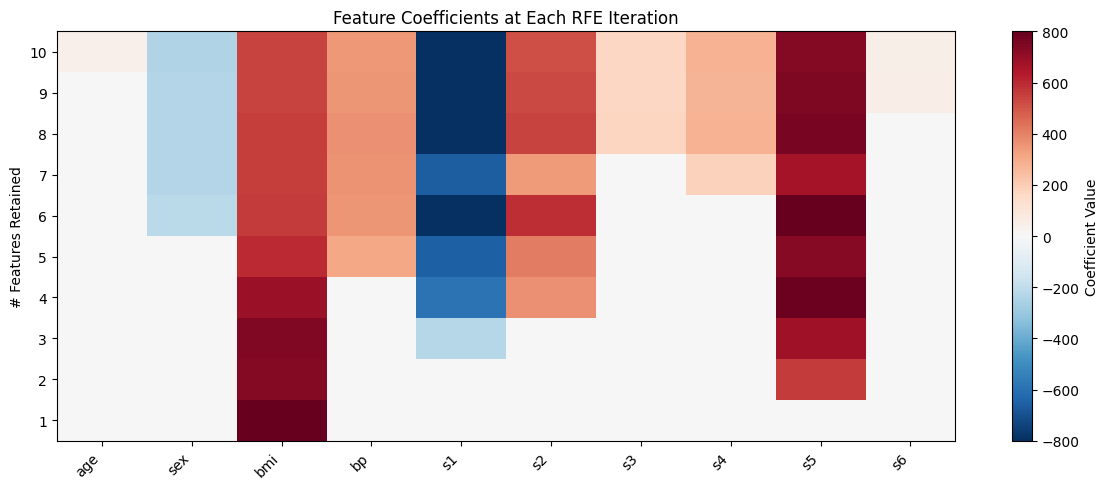

In [9]:
# Coefficient heatmap
coeff_heat = coeff_df[feature_names].astype(float)
fig, ax = plt.subplots(figsize=(12, 5))
im = ax.imshow(coeff_heat.values, aspect='auto', cmap='RdBu_r', vmin=-800, vmax=800)
ax.set_xticks(range(len(feature_names)))
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.set_yticks(range(len(coeff_heat)))
ax.set_yticklabels(coeff_heat.index)
ax.set_ylabel('# Features Retained')
ax.set_title('Feature Coefficients at Each RFE Iteration')
plt.colorbar(im, ax=ax, label='Coefficient Value')
plt.tight_layout()
plt.show()

In [10]:
# Top 3 most important features by abs coefficient (full model)
top3 = pd.Series(lr.coef_, index=feature_names).abs().sort_values(ascending=False).head(3)
print('Top 3 features by absolute coefficient magnitude (full model):')
display(top3.to_frame('|Coefficient|').round(2))

print('\nInitial ranking (full model, by |coeff|):')
display(pd.Series(lr.coef_, index=feature_names).abs().sort_values(ascending=False).to_frame('|Coefficient|').round(2))

opt_row = r2_df[r2_df['n_features'] == optimal_n].iloc[0]
print(f'\nFeatures selected at optimal n={optimal_n}: {opt_row["selected"]}')

Top 3 features by absolute coefficient magnitude (full model):


,|Coefficient|
s1,931.49
s5,736.20
bmi,542.43



Initial ranking (full model, by |coeff|):


,|Coefficient|
s1,931.49
s5,736.20
bmi,542.43
s2,518.06
bp,347.70
s4,275.32
sex,241.96
s3,163.42
s6,48.67
age,37.90



Features selected at optimal n=6: ['sex', 'bmi', 'bp', 's1', 's2', 's5']


## Task 5: Reflection

### Q1. What did you learn about feature selection using RFE?
RFE is a wrapper method that trains a model repeatedly, removing the weakest feature at each step based on coefficient magnitude. This makes it model-specific and computationally heavier than filter methods, but it captures feature interactions. The process revealed that the diabetes dataset's predictive power is concentrated in a handful of features (bmi, s5, bp), and adding more features beyond the optimal number can actually **decrease** R² slightly due to overfitting noise.

### Q2. How does RFE compare to LASSO in terms of methodology and results?
LASSO adds an L1 penalty to shrink less-important coefficients to exactly zero, performing implicit feature selection in a single model fit. RFE, on the other hand, iteratively retrains and eliminates features — making it a **wrapper** method vs. LASSO's **embedded** method. LASSO is faster and provides a continuous path of solutions (via the regularization parameter), while RFE gives a more explicit ranking. Both tend to select overlapping important features (bmi, s5), but LASSO's solution depends heavily on the choice of α, whereas RFE's depends on the elimination criterion.

### Q3. What insights can you draw from the selected features?
The most influential features — **s5** (log serum triglycerides), **bmi** (body mass index), and **bp** (blood pressure) — are well-established clinical indicators of metabolic syndrome. High BMI and elevated blood pressure are direct risk factors for diabetic progression, while serum triglycerides reflect insulin resistance. The elimination of **age** and **sex** early in RFE suggests they contribute little incremental predictive power once metabolic biomarkers are included, which aligns with clinical literature where physiological markers outperform demographics alone.